# In this Notebook we are attempting to predict if a person will win their next fight depending on how they performed on their last 5 fights

## Library Imports

In [1]:
import sys
sys.path.insert(1, '../helpers')
from make_career import make_career

import pandas as pd
import numpy as np
import talos as ta
from talos.model.normalizers import lr_normalizer
from talos.model.hidden_layers import hidden_layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import shuffle

# Model imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import binary_crossentropy
from keras.activations import relu, elu, sigmoid

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading the dataset

In [2]:
score_cols = ['precision', 'recall', 'fbeta_score', 'support']

features, labels = make_career(N_FIGHT_CAREER=5)
labels = labels.reshape(-1,)

Creating careers using 5 fight intervals and predicting 1 future fights
Original fight data shape: (5062, 153)
Fights 2x shape: (10124, 95)
Fights after pre-processing: (10124, 100)

Features shape: (3220, 5)
Labels shape: (3220, 1)

Features is a 2D matrix with 3220 rows
Each row contains has 5 fights, and each fight has 100 columns

Labels is a 2D matrix with 3220 rows
Each row contains the the prediction for the next 1 fight(s)


In [3]:
print(features.shape, labels.shape)

(3220, 5) (3220,)


## Preprocess Features

In [4]:
# Extract numerical and categorical columns
def get_column_types():
    num_cols = []
    cat_cols = []
    for fight in features[0][0]:
        feature_type = type(features[1][1][fight])
        if feature_type is not float and feature_type is not int:
            cat_cols.append(fight)
        else:
            num_cols.append(fight)
            
    return num_cols, cat_cols

# Get the first fight window and the first fight in that window
def collapse_n_fights():
    num_cols, cat_cols = get_column_types()
    
    # Collect only the features we want
    new_features = []
    for window in features:
        window_arr = list(window.reshape(1,-1))[0]
        fight_window = np.array([])
        for fight in window_arr:
            fight_arr = np.array([fight[i] for i in num_cols])
            np.nan_to_num(fight_arr, copy=False)
            fight_window = np.append(fight_window, fight_arr)
        new_features.append(fight_window)
    
    new_features, new_labels = shuffle(np.array(new_features), labels)
    X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, random_state=0, train_size=0.90)
    
    # Scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print('X_train length {}, y_train length {}'.format(X_train.shape, y_train.shape))
    print('X_test length {}, y_test length {}'.format(X_test.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

### Generates np.array of shape (3220, 5, win?)

# Score Plotter

In [5]:
def plot_training_results(history_obj):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    fig, (accuracy_axis, loss_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc, 'bo', label='Training acc')
    accuracy_axis.plot(epochs, val_acc, 'b', label='Validation acc')
    accuracy_axis.set_title('Training and validation accuracy')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()

    loss_axis.plot(epochs, loss, 'bo', label='Training loss')
    loss_axis.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_axis.set_title('Training and validation loss')
    loss_axis.set_ylim(0, 3)
    loss_axis.set_ylabel('Loss')
    loss_axis.set_xlabel('Epoch')
    loss_axis.legend()
    fig.show()

# Model Builds for LSTM, DNN and CNN

In [6]:
lstm_scores = []
def get_lstm(x_train, y_train, x_val, y_val, test_model=False):
    model = Sequential()
    
    model.add(LSTM(50, 
                   input_shape=(5, 97),
                   recurrent_dropout=0.2)) #, return_sequences=True
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.01), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=64,
                       epochs=30,
                       verbose=1)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    lstm_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model


dnn_scores = []
def get_dnn(x_train, y_train, x_val, y_val, params, test_model=False):
    
    model = Sequential()
    # Input Layer
    model.add(Dense(params['first_neuron'], 
                    activation=params['activation'], 
                    input_dim=X_train.shape[1]))
    
    model.add(Dropout(params['dropout']))
    
    # Hidden Layers
    hidden_layers(model, params, 1)
    
    # Output Layers
    model.add(Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
                  
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    dnn_scores.append(score)
    
    if test_model:
        model.summary()
        plot_training_results(history)
        

    return history, model


cnn_scores = []
def get_cnn(x_train, y_train, x_val, y_val, params, test_model=False):
    model = Sequential()
    
    # Convolutional Layers
    model.add(Conv1D(filters=params['num_filters'], kernel_size=params['kernel_size'], activation='relu', input_shape=(5, 97)))
    model.add(Conv1D(filters=params['num_filters'], kernel_size=params['kernel_size'], activation='relu'))
    model.add(Dropout(params['dropout']))
#     model.add(MaxPooling1D(pool_size=2))
    
    # Flatten Layers
    model.add(Flatten())
    model.add(Dense(params['flatten_layer'], activation='relu'))
#     model.add(Dense(params['flatten_layer'], activation='relu'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    cnn_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

## Building a DNN to predict the winner using last n fights

In [7]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)


In [8]:
# Define hyperparameters to use in Grid Search
dnn_params = {
    'lr': [0.01, 1, 2],
    'first_neuron': [128, 256],
    'hidden_layers': [1, 2],
    'batch_size': [64, 128, 256],
    'epochs': [10, 25],
    'dropout': [0.01, 0.1],
    'optimizer': [Adam],
    'shapes':['funnel'],
    'losses': [binary_crossentropy],
    'activation': [relu],
    'last_activation': [sigmoid],
}

# Create the Neural Network
dnn_model = ta.Scan(
    x=X_train,
    y=y_train,
    model=get_dnn,
    params=dnn_params,
    experiment_name='UFC_5_Fight_Predictor_DNN',
)

100%|██████████| 144/144 [05:49<00:00,  2.43s/it]


In [10]:
results_df = dnn_model.data
print(results_df.shape, len(dnn_scores))
dnn_cols = list(results_df.columns)

new_df_data = []

for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in dnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = dnn_scores[index][score_index]
        
    new_df_data.append(new_row)

dnn_df = pd.DataFrame(new_df_data)
dnn_df.sort_values(by=['val_accuracy'], ascending=False, inplace=True)
dnn_df.to_csv('model_results/UFC_Predict_5_Fights_DNN.csv')

top_5_val_dnn = dnn_df.drop(columns=['activation', 'last_activation', 'optimizer', 'support', 'losses']).head(5)
top_5_val_dnn

(144, 16) 144


,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,epochs,first_neuron,hidden_layers,lr,shapes,precision,recall,fbeta_score
11,10,0.705158,0.597701,0.627495,0.648422,64,0.01,10,256,2,2.00,funnel,0.597730,0.938614,0.730354
34,10,0.807922,0.596552,0.568007,0.617357,64,0.10,10,256,2,1.00,funnel,0.597468,0.934653,0.728958
100,10,0.753153,0.591954,0.479932,0.766272,256,0.01,10,128,2,1.00,funnel,0.614329,0.798020,0.694229
17,25,1.307102,0.585057,0.411733,0.767258,64,0.01,25,128,2,2.00,funnel,0.606509,0.811881,0.694327
141,25,0.689004,0.582759,0.678279,0.574951,256,0.10,25,256,2,0.01,funnel,0.585337,0.964356,0.728497


## Building a CNN to predict the winner using last n fights

In [11]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print('New: X_train length {}, y_train length {}'.format(X_train.shape, y_train.shape))
print('New: X_test length {}, y_test length {}'.format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


In [12]:
# Define hyperparameters to use in Grid Search
cnn_params = {
    'lr': [0.01, 0.1, 1],
    'num_filters': [64, 128],
    'kernel_size': [2],
    'batch_size': [64, 128],
    'epochs': [5, 15],
    'dropout': [0.01],
    'flatten_layer': [100, 150], 
    'optimizer': [Adam],
    'losses': [binary_crossentropy],
    'activation': [relu],
    'last_activation': [sigmoid],
}

# Create the Neural Network
cnn_model = ta.Scan(
    x=X_train,
    y=y_train,
    model=get_cnn,
    params=cnn_params,
    experiment_name='UFC_5_Fight_Predictor_CNN',
)

100%|██████████| 48/48 [01:40<00:00,  2.09s/it]


In [13]:
results_df = cnn_model.data
cnn_cols = list(results_df.columns)
print(results_df.shape, len(cnn_scores))

new_df_data = []

for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in cnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = cnn_scores[index][score_index]
        
    new_df_data.append(new_row)

cnn_df = pd.DataFrame(new_df_data)
cnn_df.sort_values(by=['val_accuracy'], ascending=False, inplace=True)
cnn_df.to_csv('model_results/UFC_Predict_5_Fights_CNN.csv')

top_5_val_cnn = cnn_df.drop(columns=['activation', 'last_activation', 'optimizer', 'support', 'losses']).head(5)
top_5_val_cnn

(48, 16) 48


,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,epochs,flatten_layer,kernel_size,lr,num_filters,precision,recall,fbeta_score
20,15,0.681543,0.594253,0.598223,0.701183,64,0.01,15,150,2,0.10,64,0.614925,0.812623,0.700085
2,5,0.679279,0.583908,0.662083,0.608974,64,0.01,5,100,2,0.10,64,0.604017,0.830375,0.699336
9,5,0.674639,0.581609,0.638587,0.639053,64,0.01,5,150,2,0.10,128,0.604685,0.814596,0.694118
39,15,0.692462,0.577011,0.566163,0.740138,128,0.01,15,100,2,0.10,128,0.609795,0.761341,0.677193
13,15,0.681895,0.577011,0.660421,0.593688,64,0.01,15,100,2,0.01,128,0.596127,0.850099,0.700813


## Building an LSTM to predict the winner using last n fights

In [14]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print('New: X_train length {}, y_train length {}'.format(X_train.shape, y_train.shape))
print('New: X_test length {}, y_test length {}'.format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


Train on 2898 samples, validate on 322 samples
Epoch 1/30
2898/2898 [==============================] - 1s 232us/step - loss: 0.6932 - accuracy: 0.5635 - val_loss: 0.6836 - val_accuracy: 0.5683
Epoch 2/30
2898/2898 [==============================] - 0s 101us/step - loss: 0.6503 - accuracy: 0.6128 - val_loss: 0.6954 - val_accuracy: 0.5497
Epoch 3/30
2898/2898 [==============================] - 0s 117us/step - loss: 0.6243 - accuracy: 0.6601 - val_loss: 0.6912 - val_accuracy: 0.5528
Epoch 4/30
2898/2898 [==============================] - 0s 108us/step - loss: 0.5871 - accuracy: 0.6939 - val_loss: 0.7474 - val_accuracy: 0.5559
Epoch 5/30
2898/2898 [==============================] - 0s 108us/step - loss: 0.5300 - accuracy: 0.7447 - val_loss: 0.7749 - val_accuracy: 0.5342
Epoch 6/30
2898/2898 [==============================] - 0s 121us/step - loss: 0.4849 - accuracy: 0.7709 - val_loss: 0.7878 - val_accuracy: 0.5528
Epoch 7/30
2898/2898 [==============================] - 0s 111us/step - loss:

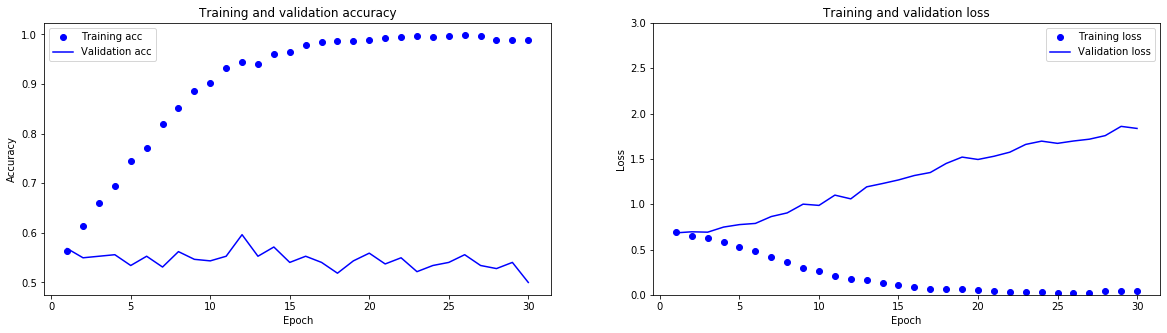

In [15]:
history, model = get_lstm(X_train, y_train, X_test, y_test, test_model=True)

In [16]:
hist = history.history
lstm_data = [hist['accuracy'][-1], hist['val_accuracy'][-1], hist['loss'][-1], hist['val_loss'][-1]]
lstm_data = lstm_data + [lstm_scores[0][0], lstm_scores[0][1], lstm_scores[0][2], lstm_scores[0][3]]
lstm_cols = ['accuracy', 'val_accuracy', 'loss', 'val_loss'] + score_cols


lstm_df = pd.DataFrame(data=[lstm_data], columns=lstm_cols)
lstm_df.sort_values(by=['val_accuracy'], ascending=False, inplace=True)
lstm_df.to_csv('model_results/UFC_Predict_5_Fights_LSTM.csv')
lstm_df.head(5)

,accuracy,val_accuracy,loss,val_loss,precision,recall,fbeta_score,support
0,0.988613,0.5,0.0472,1.836213,0.5625,0.625668,0.592405,None
